# 2D EPA implementation


## <font color='blue'> Load nescesssary modules

In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

import os
import numpy as np
import matplotlib.pyplot as plt


from psc.lib.g_space import g, hsurf_g
from psc.lib.x2Dlinearize import double_segment_EPA, single_segment_EPA 
from psc.lib.x2Dpolygon import getploygons_EPA_SS, getploygons_EPA_DS, polyintersect, polyintersect_MC
from psc.lib.x2Drepetition import linrep_DS, linrep_SS, writedata
from psc.lib.x3Drepetition import getmesh
from psc.tools.x2Dplot import plot_segment, plotisosurf_EPA
from psc.lib.x2Dwritesolution import analyzesolution

## <font color='blue'> 2D - EPA: Double-segments  (DS)

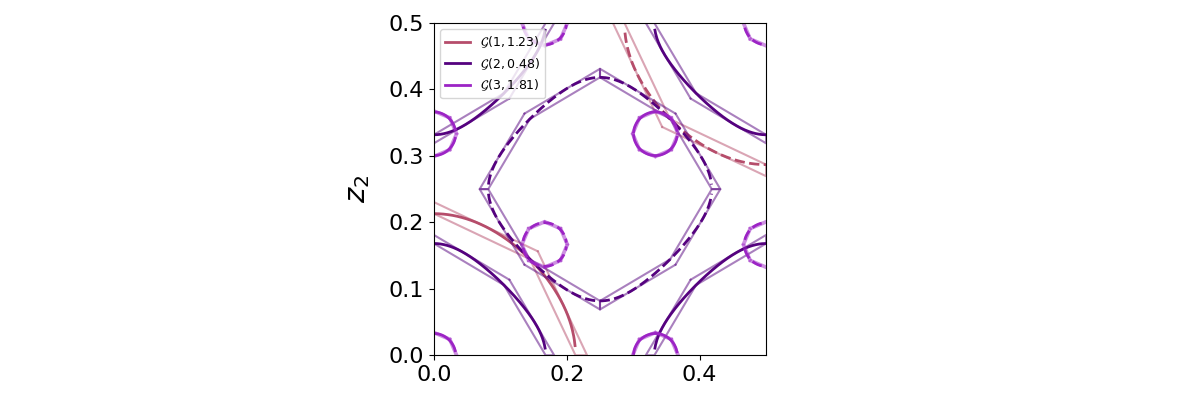

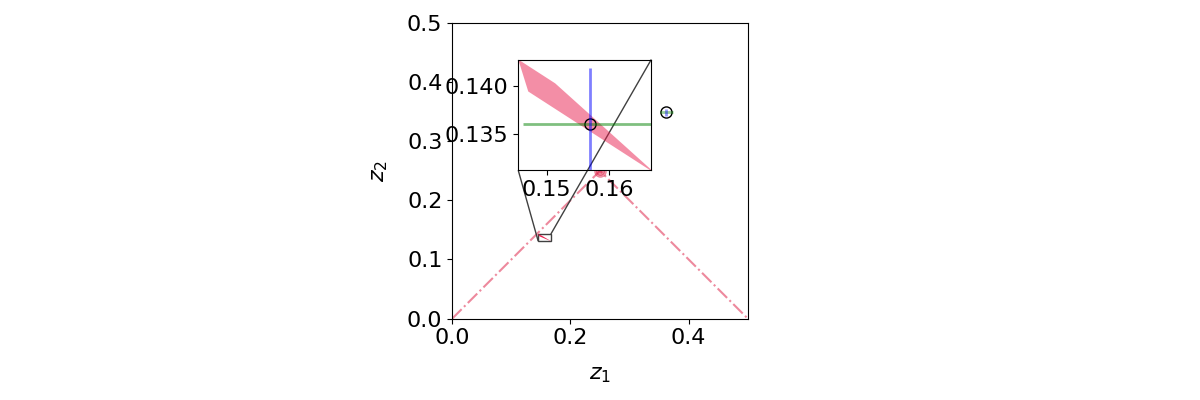

===> Possible solution (centorid of polygon) :: [0.15364 0.13775] or [0.34636 0.36225]
===> Assumed coordinate: [0.362 0.349]
===> Possible uncertainty in solution :: (np.float64(-0.010686850481930063), np.float64(-0.005873478390791692))
===> Finals area                      :: 3.5697497270902645e-05



In [4]:

### define random strucutre
xcoor  = [0.349, 0.362]

### assume we solve for second atomic corrdinate 
j     = 1

### defining number of reflection orders to consider
h     = 3
hss   = np.arange(1,h+1)

### generating possible atomic corrdinates in 2D PS. hence grid has dimension of 2x500. 
isos = np.linspace(0., (0.5)/1, 500)  # !!! to change the precision in isosurface change 500 to higher number
grid = [isos]*len(xcoor)

### define plot container
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,4), subplot_kw = dict(aspect = 1.0))
fig.tight_layout()
ax.set_xlim(isos.min(), isos.max()) ; ax.set_ylim(isos.min(), isos.max())
ax.set_xlabel(r'$z_1$' ,fontsize=21,labelpad=12) ; ax.set_ylabel(r'$z_2$' ,fontsize=21,labelpad=12)
plt.rc('xtick', labelsize=16) ; plt.rc('ytick', labelsize=16)

### open a dat file to store data
fn=open("xpnts_%g.dat"%(h), "wt+")  

### staring amplitude calculation for each RO h and plot them
for ic, l in enumerate(hss):
    xcoor  = np.sort(xcoor)[::-1]
    
    # EPA model
    f     = [1, 1]
    
    # calculate amplitude for given strucutre and RO
    gi    = np.abs(g(l, xcoor, f))
    
    # calculate the isosurface over entrie PS using above gi for s=+1 and s=-1
    giso1 = hsurf_g(l, grid, f, gi, j, s=1)
    giso2 = hsurf_g(l, grid, f, gi, j, s=-1)

    # plot calculated isosurfcae. define cc='k' if same is wanted. or isosurface colour will change automatically
    r = np.random.uniform(0.0, 0.8, 3) ; cc = (r[0],r[1],r[2],1)
    plotisosurf_EPA(l, h, gi, ax, isos, giso1, giso2, cc, lw=2, imax=0.5)
    
    #---> inearization process with error of err 
    errr = 0
    meshlist = getmesh(l, xcoor, isos.max())

    #---> double segment method - EPA
    pnts = double_segment_EPA(gi, l, f, error=0)
    plist=linrep_DS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> single segment method - EPA
    #pnts = single_segment_EPA(gi, l, xexp, f, error=0)
    #plist=linrep_SS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> plot segments
    plot_segment(ax, plist, cc)

    #---> storing segment data
    writedata(fn, plist)

fn.close()

plt.legend(loc=2, prop={'size': 9})#, bbox_to_anchor=(1.0, 1.020))
plt.show()


# ---> Post processing to get the given atomic coordinates

# ---> Reading corner points of polygons of given ROs
pointlst = np.loadtxt(os.path.join(os.getcwd(),'xpnts_%g.dat'%(h)),delimiter='\t')

# ---> Getting polygons of given ROs
poly = getploygons_EPA_DS(h, pointlst, imax=0.5)

# ---> Finding solution via intersection of polygons of given ROs
with open ('info.dat', "at+") as finfo:
    solution = polyintersect_MC(h, poly, xcoor, finfo, count=0 )

# ---> Writting found solutions from given ROs
analyzesolution(solution, xcoor, plotting=True)

In [5]:
def double_segment_EPA1(gi, l, f, error=0):
    
    #### Jonas Area 
    k    = 2*np.pi*l ;  gi   = np.abs(gi)
    
    #### Finding point p1 and p2  
    p1x  = (1/k)*np.arccos(gi*(1+error)/np.sum(f)) ;       #  x2* = x1*
    p1y  = p1x
    
    p2x  = (1/k)*np.arccos(gi*(1+error)-1)         #  x1* = pnt2 ; x2* = 0
    p2y  = 0
    
    m1   = (p2y-p1y)/(p2x-p1x)           # slope of First line
    n1   = find_interception(p2x,p2y,m1)
        
    #### Finding point p3, p4 and p5
    
    j = 1
    p5 = fn_solveforx_v3(l, gi, f, m1, j, error)[0]
    p5x, p5y = p5[0], p5[1]
    
    n2   = find_interception(p5x,p5y,m1)
    
    p4x  = -n2 / (m1-1)
    p4y  = p4x
    
    p3x  = -n2/m1
    p3y  = 0
    
    #pnt  = np.array([p1x, p1y, p2x, p2y, p3x, p3y, p4x, p4y, p5x, p5y])
    pnt  = np.array([[p1x, p1y], [p2x, p2y], [p3x, p3y], [p5x, p5y], [p4x, p4y]])
    
    return pnt

def single_segment_EPA1(gi, l, f, error=0):
    #### Jonas Area 
    k    = 2*np.pi*l
    gi   = np.abs(gi)
    
    #### Finding point p1 and p2  
    
    p1x  = (1/k)*np.arccos(gi*(1+error)-1)         #  x1* = pnt2 ; x2* = 0
    p1y  = 0
    
    p2y  = (1/k)*np.arccos(gi*(1+error)-1)         #  x1* = pnt2 ; x2* = 0
    p2x  = 0
    
    m1   = (p2y-p1y)/(p2x-p1x)           # slope of First line
    n1   = find_interception(p2x,p2y,m1)
        
    #### Finding point p3, p4 and p5
    
    p5x = (1/k)*np.arccos(gi*(1-error)/np.sum(f))
    p5y = p5x #p4  = [xp]*len(f)
    
    n2   = find_interception(p5x,p5y,m1)
    
    p4y  = n2 #/ (m1-1)  # y = m1x+n2
    p4x  = 0 #p4x
    
    p3x  = -n2/m1
    p3y  = 0
    
    pnt  = np.array([[p2x, p2y], [p1x, p1y], [p3x, p3y], [p5x, p5y], [p4x, p4y]])
    
    return pnt

# ----------------------------------------------
# ====================> nEPA linearization
# ----------------------------------------------

def find_interception(x,y,m):
    return y-m*x
def findpx(y,h,gi,f):
    k=2*np.pi*h
    return (1/k)*np.arccos(gi/f[0] - (f[1]/f[0])*np.cos(k*y))

def single_segment_nEPA1(gi, l, f, j=1, error=0):
    pnt = []
    
    k   = 2*np.pi*l
    gi   = np.abs(gi)
      
    p1x  = 0
    p1y  = (1/k)*np.arccos((gi*(1+error)-f[0])/f[1])
    
    if np.isnan(p1y):
        p1y = 0.5/l
        p1x = findpx(p1y, l, gi, f)
        pnt.append([p1x, p1y])
        
    else:
        pnt.append([p1x, p1y])        
     
    
    p2x  = (1/k)*np.arccos((gi*(1+error)-f[1])/f[0])
    p2y  = 0
    pnt.append([p2x, p2y]) 
    
    
    m1   = (p2y-p1y)/(p2x-p1x)
    n1   = find_interception(p2x,p2y,m1)
    
    p4   = fn_solveforx_v3(l, gi, f, m1, j, error)
            
    if ~np.all(np.isnan(p4)):
        
        if len(p4) > 1:
            pnt = []
            
            if (p4[0,1]/p4[0,0]) <= 1 and (p4[1,1]/p4[1,0]) > 1:
            #if np.floor(p4[0,1]/p4[0,0]) <= 1 and np.floor(p4[1,1]/p4[1,0]) > 1:
                pLB=p4[0]
                pUB=p4[1]
            else:
                pLB=p4[1]
                pUB=p4[0]
            
            ### Lower Boundary (LB)
            nLB = pLB[1] - m1*pLB[0]
            
            pLB1y = 0.5/l
            pLB1x = (pLB1y - nLB)/m1
            
            pLB3x = np.abs(nLB/m1)
            pLB3y = 0
            #pLB3x = (1/k)*np.arccos((g*(1+error)-f[0])/f[1])
                        
            ### Upper Boundary (UB)
            
            nUB = pUB[1] - m1*pUB[0]
            pUB4x = np.abs(nUB/m1)
            pUB4y = 0
            
            pUB6y = 0.5/l
            pUB6x = (pUB6y - nUB)/m1
            
            ### Colloecting point in order
            pnt.append([pLB1x,  pLB1y])
            pnt.append([pLB[0], pLB[1]])
            pnt.append([pLB3x,  pLB3y])
            
            pnt.append([pUB4x,  pUB4y])
            pnt.append([pUB[0], pUB[1]])
            pnt.append([pUB6x,  pUB6y])
                        
            return np.array(pnt)
        
        elif ~np.all(np.isnan(p4)):
            p4y = p4[0][1]
            p4x = p4[0][0]
        else:
            
            p4y = 0.5/l
            p4x  = (1/k)*np.arccos( gi/f[0] - (f[1]/f[0])*np.cos(k*p4y) )
    
    n2   = find_interception(p4x,p4y,m1)
    p3x  = -n2/m1
    p3y  = 0
    
    pnt.append([p3x, p3y])
    pnt.append([p4x, p4y])
    
    p5x  = 0
    p5y  = n2
    
    if p5y > 0.5/l:
        p5y  = 0.5/l
        p5x = (p5y-n2)/m1
        pnt.append([p5x, p5y])
        
        pextra_x = 0
        pextra_y = 0.5/l
        pnt.append([pextra_x, pextra_y])
    else:
        pnt.append([p5x, p5y])
        
    return np.array(pnt)

def double_segment_nEPA1(gi, l, f, j=1, error=0):
    pnt, pntLB, pntUB = [], [], []
    
    k   = 2*np.pi*l
    gi   = np.abs(gi) 
    
    p1x = (1/k)*np.arccos(gi*(1+error)/np.sum(f))
    p1y = p1x
    
    p2y = 0
    p2x = (1/k)*np.arccos((gi*(1+error)-f[1]*np.cos(k*p2y))/f[0])
    if np.isnan(p2x):
        p2x = 0.5/l
        
    m1  = (p2y-p1y)/(p2x-p1x)
    n1  = find_interception(p2x,p2y,m1)
    
    p5   = fn_solveforx_v3(l, gi, f, m1, j, error)
    
    # ---> get lower and upper tangent points
    if ~np.all(np.isnan(p5)):
        if len(p5) > 1:
            if (p5[0,1]/p5[0,0]) <= 1 and  (p5[1,1]/p5[1,0]) <= 1:
                pLB=p5
            elif (p5[0,1]/p5[0,0]) <= 1 and (p5[1,1]/p5[1,0]) > 1:
                pLB=p5[0]
                pUB=p5[1]
            else:
                pLB=p5[1]
                pUB=p5[0]
        elif len(p5) == 1 :
            pLB = p5[0]
        else:
            p5y = 0.5/l
            p5x = (1/k)*np.arccos( gi/f[0] - (f[1]/f[0])*np.cos(k*p5y) )
            pLB = np.array([p5x, p5y])
    
    # ---> use only lower tangent points for lower part
    nLB = pLB[1] - m1*pLB[0]
    p3x = np.abs(nLB/m1)
    p3y = 0
    
    p4x = nLB / (1-m1)
    p4y = p4x
    
    ### Colloecting point in order
    pnt.append([p1x, p1y])
    pnt.append([p2x, p2y])
    pnt.append([p3x, p3y])
    pnt.append([pLB[0], pLB[1]])
    pnt.append([p4x, p4y])
    
    # ---> Part 2 linearize upper part of isosurface
    p8x = 0
    p8y = (1/k)*np.arccos((gi*(1+error)-f[0])/f[1])
    if np.isnan(p8y):
        p8y = 0.5/l
        p8x = (1/k)*np.arccos( (gi*(1+error)-f[1]*np.cos(k*p8y))/f[0] )
    
    m2  = (p8y-p1y)/(p8x-p1x)
    n2  = find_interception(p8x,p8y, m2)
    
    p11 = fn_solveforx_v3(l, gi, f, m2, j, error)
    
    # ---> get lower and upper tangent points
    if ~np.all(np.isnan(p11)):
        if len(p11) > 1:
            if (p11[0,1]/p11[0,0]) < 1 and (p11[1,1]/p11[1,0]) >= 1:
                pLB=p11[0]
                pUB=p11[1]
                p10=np.array([p11[1]])
            elif (p11[0,1]/p11[0,0]) >= 1 and (p11[1,1]/p11[1,0]) >= 1:
                p10=p11
                pLB=p11[0]
                pUB=p11[1]
            else:
                p10=p11[1]
                pLB=p11[1]
                pUB=p11[0]
        elif len(p11) == 1 :
            pUB = p11[0]
            p10 = p11
        else:
            p11y = 0.5/l
            p11x = (1/k)*np.arccos( gi/f[0] - (f[1]/f[0])*np.cos(k*p11y) )
            pUB = np.array([p11x, p11y])
            p10 = pUB
    
    if len(p10) >1:
        # ---> use only lower tangent points for lower part
        
        p14x=pLB[0] ; p14y=pLB[1]
        
        nUB1=pLB[1]-m2*pLB[0]
        p15y = 0.5/l
        p15x = (p15y - nUB1)/m2
        
        p16x = nUB1 / (1-m2)
        p16y = p16x
        
        pnt.append([p16x, p16y])
        pnt.append([p14x, p14y])
        pnt.append([p15x, p15y])  

        nUB = pUB[1] - m2*pUB[0]
        p12y = 0.5/l
        p12x = (p12y - nUB)/m2
        
        p13x = nUB / (1-m2)
        p13y = p13x       
        
        pnt.append([p12x, p12y])
        pnt.append([pUB[0], pUB[1]])
        pnt.append([p13x, p13y])   
    else:
        nUB = pUB[1] - m2*pUB[0]
        
        ptypex = 0
        ptypey = (1/k)*np.arccos( (gi*(1+error)-f[0]*np.cos(k*ptypex))/f[1] )
        
        if np.isnan(ptypey):
            #print("---> I found type II isosurface")
            p12y = 0.5/l
            p12x = (p12y - nUB)/m2
        else:
            #print("---> I found type I isosurface")
            p12x = 0 
            p12y = nUB
        
        p13x = nUB / (1-m2)
        p13y = p13x
        
        pnt.append([p1x, p1y])
        pnt.append([p8x, p8y])
        pnt.append([p12x, p12y])
        pnt.append([pUB[0], pUB[1]])
        pnt.append([p13x, p13y])   
        pnt.append([p1x, p1y])
                
    return np.array(pnt)

def findpy(x,h,gi,f):
    k=2*np.pi*h
    return (1/k)*np.arccos(gi/f[1] - (f[0]/f[1])*np.cos(k*x))

def fn_solveforx_v3(l, gi, f, m, j, error):
    
    k = 2 * np.pi * l
    
    i = list(range(j)) + list(range(j+1,len(f)))
    
    a = (1-m*m)/(f[j]*f[j])
    b = 2 * m*m * gi /(f[j]*f[j])
    c = m*m*( 1 - (gi*gi) / (f[j]*f[j]) ) - np.array([ (f[ii]*f[ii]) / (f[j]*f[j]) for ii in i]).sum(axis = 0) 
    
    
    if a != 0:
        
        z1 = (-b + np.sqrt(b*b - 4*a*c))/(2*a)
        z2 = (-b - np.sqrt(b*b - 4*a*c))/(2*a)
        
        r1=(1/k)*np.arccos(z1/f[0])
        r2=(1/k)*np.arccos(z2/f[0])
        
        if ~np.isnan(r1) and np.isnan(r2):
            ry=findpy(r1, l, gi, f)
            return np.array([[r1, ry]])
        
        elif np.isnan(r1) and ~np.isnan(r2):
            ry=findpy(r2, l, gi, f)
            return np.array([[r2, ry]])
        
        elif np.isnan(r1) and np.isnan(r2) :
            return np.array([float("nan")])
        
        elif ~np.isnan(r1) and ~np.isnan(r2):
            r1y=findpy(r1, l, gi, f)
            r2y=findpy(r2, l, gi, f)
            return np.array([ [r1, r1y], [r2, r2y] ])
        
        else:
            return np.array([r1, r2])
    
    else:
        z1 = (-1*c/b)
        
        r1=(1/k)*np.arccos(z1/f[0])
        
        if ~np.isnan(r1):
            ry=findpy(r1, l, gi, f)
            return np.array([r1, ry])
        elif np.isnan(r1):
            prx = (1/k)*np.arccos(gi*(1+error)/np.sum(f))
            pry = prx
            return np.array([[prx, pry]])
        else:
            prx = (1/k)*np.arccos(gi*(1+error)/np.sum(f))
            pry = prx
            return np.array([[prx, pry]])

## <font color='blue'> 2D - EPA: Single-segments  (SS)

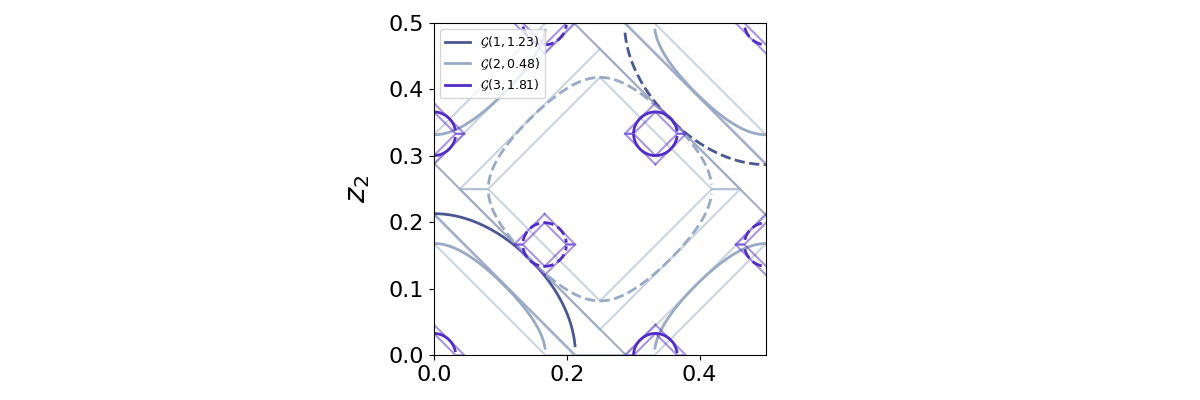

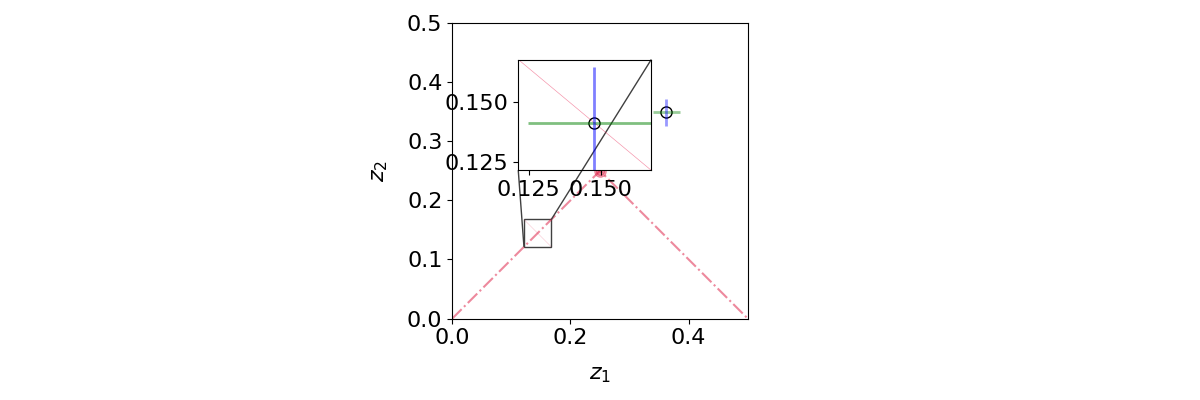

===> Possible solution (centorid of polygon) :: [0.14452 0.14452] or [0.35548 0.35548]
===> Assumed coordinate: [0.362 0.349]
===> Possible uncertainty in solution :: (np.float64(-0.02313102460156486), np.float64(-0.02313102460156486))
===> Finals area                      :: 1.566483117376022e-05



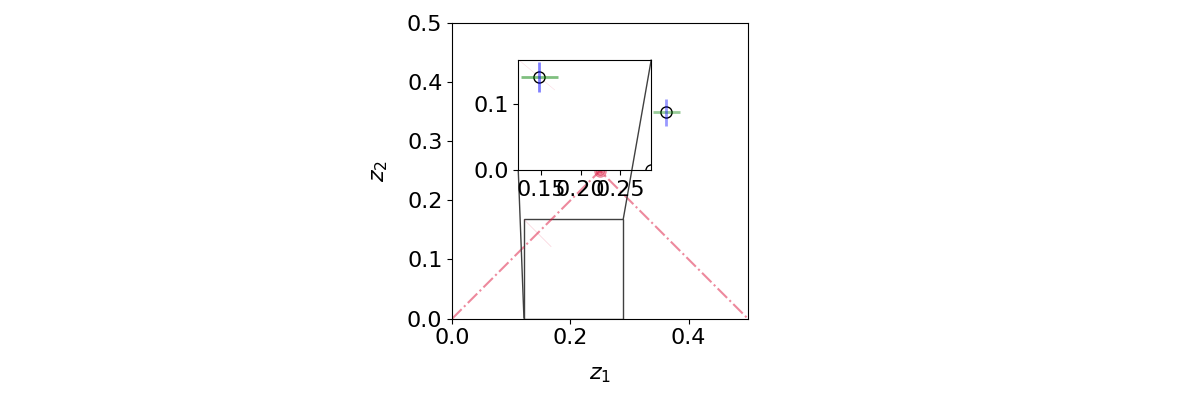

===> Possible solution (centorid of polygon) :: [0.28904 0.00006] or [0.21096 0.49994]
===> Assumed coordinate: [0.362 0.349]
===> Possible uncertainty in solution :: (np.float64(-0.0001699250000000152), np.float64(-8.496250293778052e-05))
===> Finals area                      :: 2.8874506623407296e-08



In [8]:

### define random strucutre
xcoor  = [0.349, 0.362]

### assume we solve for second atomic corrdinate 
j     = 1

### defining number of reflection orders to consider
h     = 3
hss   = np.arange(1,h+1)

### generating possible atomic corrdinates in 2D PS. hence grid has dimension of 2x500. 
isos = np.linspace(0., (0.5)/1, 500)  # !!! to change the precision in isosurface change 500 to higher number
grid = [isos]*len(xcoor)

### define plot container
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,4), subplot_kw = dict(aspect = 1.0))
fig.tight_layout()
ax.set_xlim(isos.min(), isos.max()) ; ax.set_ylim(isos.min(), isos.max())
ax.set_xlabel(r'$z_1$' ,fontsize=21,labelpad=12) ; ax.set_ylabel(r'$z_2$' ,fontsize=21,labelpad=12)
plt.rc('xtick', labelsize=16) ; plt.rc('ytick', labelsize=16)

### open a dat file to store data
fn=open("xpnts_%g.dat"%(h), "wt+")  

### staring amplitude calculation for each RO h and plot them
for ic, l in enumerate(hss):
    xcoor  = np.sort(xcoor)[::-1]
    
    # EPA model
    f     = [1, 1]
    
    # calculate amplitude for given strucutre and RO
    gi    = np.abs(g(l, xcoor, f))
    
    # calculate the isosurface over entrie PS using above gi for s=+1 and s=-1
    giso1 = hsurf_g(l, grid, f, gi, j, s=1)
    giso2 = hsurf_g(l, grid, f, gi, j, s=-1)

    # plot calculated isosurfcae. define cc='k' if same is wanted. or isosurface colour will change automatically
    r = np.random.uniform(0.0, 0.8, 3) ; cc = (r[0],r[1],r[2],1)
    plotisosurf_EPA(l, h, gi, ax, isos, giso1, giso2, cc, lw=2, imax=0.5)
    
    #---> inearization process with error of err 
    errr = 0
    meshlist = getmesh(l, xcoor, isos.max())

    #---> double segment method - EPA
    #pnts = double_segment_EPA(gi, l, xcoor, f, error=0)
    #plist=linrep_DS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> single segment method - EPA
    pnts = single_segment_EPA(gi, l, f, error=0)
    plist=linrep_SS(l, f, pnts, meshlist, imin=0, imax=0.5)

    #---> plot segments
    plot_segment(ax, plist, cc)

    #---> storing segment data
    writedata(fn, plist)

fn.close()

plt.legend(loc=2, prop={'size': 9})#, bbox_to_anchor=(1.0, 1.020))
plt.show()


# ---> Post processing to get the given atomic coordinates


# ---> Reading corner points of polygons of given ROs
pointlst = np.loadtxt(os.path.join(os.getcwd(),'xpnts_%g.dat'%(h)),delimiter='\t')

# ---> Getting polygons of given ROs
poly = getploygons_EPA_SS(h, pointlst, imax=0.5)

# ---> Finding solution via intersection of polygons of given ROs
with open ('info.dat', "at+") as finfo:
    solution = polyintersect_MC(h, poly, xcoor, finfo, count=0 )

# ---> Writting found solutions from given ROs
analyzesolution(solution, xcoor, plotting=True)